# Group 41 Project Report

## Maternal Health Data and Health Risk Level

#### Research Question: To what extent can we use model data from “sensing enabled technology”: blood pressure, blood glucose level, body temperature and heart rate, to classify and predict Bangladeshi women’s maternal health risk level?

### Background Information 

Maternal mortality is a pervasive problem especially in developing nations, and affecting the disadvantaged classes disproportionately. It is especially unfortunate that many of these maternal fatalities are preventable. Ahmed et al. (2020) devise a method to track real-time data of pregnant women in remote/rural areas in Bangladesh through the usage of wearable sensing devices. This data can be used to classify risk factors and provide timely intervention when needed to women who might be susceptible to complications, and consequently face increased risk of maternal death. We will be using the dataset from Ahmed et al.(2020)(accessed via the UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/dataset/863/maternal+health+risk).  
**Our data has the following variables (columns):**
- Age 
- Systolic Blood Pressure (SystolicBP)
- Diastolic Blood Pressure (DiastolicBP)
- Blood Glucose Level (BS)
- Body Temperature (BodyTemp)
- Resting Heart Rate (HeartRate)
- Predicted Risk Intensity Level during pregnancy (RiskLevel)

A WHO systematic review of global causes of maternal health (Say et al., 2014) identifies hypertension as one of the most common direct causes of maternal health risk, accounting for 14% of maternal deaths. Additionally, this review finds that some indirect causes of maternal death are diabetes and older age. Thus, all the given health variables except Body Temperature shall be included in the classifier as they relate to hypertension and diabetes respectively. 

## Import Libraries

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")
library("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We have to import several libraries in order to build our model. Tidyverse and Tidymodels will be used to build the classification model later. We will also use the kknn model to perform k-nn classification strategy on the data.

## Read data from URL

In [2]:
mat_health_risk <- read_csv("https://raw.githubusercontent.com/aaronardenma/dsci-100-2023w1-group-41/main/Maternal_Health_Risk_Data_Set.csv")

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Data exploration

In [3]:
## Display the data set
mat_health_risk

Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
25,130,80,15,98,86,high risk
35,140,90,13,98,70,high risk
29,90,70,8,100,80,high risk
⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,85,60,19,98,86,high risk
43,120,90,18,98,70,high risk
32,120,65,6,101,76,mid risk


In [4]:
## Display statistical information
summary(mat_health_risk)

      Age          SystolicBP     DiastolicBP           BS        
 Min.   :10.00   Min.   : 70.0   Min.   : 49.00   Min.   : 6.000  
 1st Qu.:19.00   1st Qu.:100.0   1st Qu.: 65.00   1st Qu.: 6.900  
 Median :26.00   Median :120.0   Median : 80.00   Median : 7.500  
 Mean   :29.87   Mean   :113.2   Mean   : 76.46   Mean   : 8.726  
 3rd Qu.:39.00   3rd Qu.:120.0   3rd Qu.: 90.00   3rd Qu.: 8.000  
 Max.   :70.00   Max.   :160.0   Max.   :100.00   Max.   :19.000  
    BodyTemp        HeartRate     RiskLevel        
 Min.   : 98.00   Min.   : 7.0   Length:1014       
 1st Qu.: 98.00   1st Qu.:70.0   Class :character  
 Median : 98.00   Median :76.0   Mode  :character  
 Mean   : 98.67   Mean   :74.3                     
 3rd Qu.: 98.00   3rd Qu.:80.0                     
 Max.   :103.00   Max.   :90.0                     

From the above, we can see multiple features, including age, systolic blood pressure, diastolic blood pressure, blood glucose level, body temperature and resting heart rate. 

In common knowledge, all the above features are often good predictors in prognosis phase. Therefore, in the context of predicting risk level, we are not going to exclude any of the features as predictor. 

## Class distribution

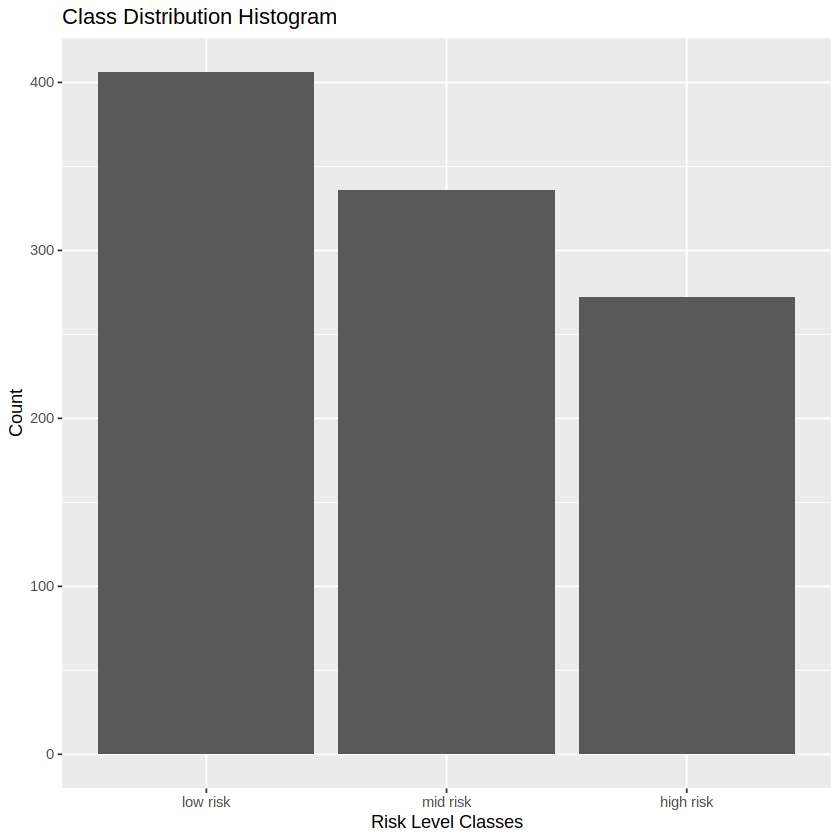

In [5]:
class_distribution_plot <- mat_health_risk |>
    select(RiskLevel) |>
    mutate(RiskLevel = factor(RiskLevel)) |>
    mutate(RiskLevel = RiskLevel |> fct_relevel("low risk", "mid risk", "high risk")) |>
    group_by(RiskLevel) |>
    summarize(count = n()) |>
    ggplot(aes(x = RiskLevel, y = count)) +
    geom_bar(stat="identity") +
    xlab("Risk Level Classes") +
    ylab("Count") +
    ggtitle("Class Distribution Histogram")

class_distribution_plot

### Observation
From the above bar plot, we can discover the problem of class imbalance. The dataset is slightly skewed to the right, meaning we can observe more low risk cases than mid risk cases, and more mid risk cases than high risk cases. The imbalance situation is still acceptable, yet, we have to keep that in mind when performing evaluation metric. That is because with a higher distribution of the negative class (i.e. low risk in our study) can lead to a higher chance of false negative if the model was not properly trained. ***Therefore, we will have to keep track on the false negative percentage while evaluating the model.***

## Train Test Split

In [6]:
set.seed(1) 

mat_health_risk <- mat_health_risk |>
    mutate(RiskLevel = as_factor(RiskLevel))

mat_health_risk_split <- initial_split(mat_health_risk, prop = 0.75, strata = RiskLevel)  
health_train <- training(mat_health_risk_split)   
health_test <- testing(mat_health_risk_split)


We have set the train-test proportion to be 75% and RiskLevel as our strata.

## Workflow Setup

In [7]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

health_recipe <- recipe(RiskLevel ~ ., data = health_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

health_vfold <- vfold_cv(health_train, v = 5, strata = RiskLevel)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

health_fit <- workflow() |>
    add_recipe(health_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = health_vfold, grid = k_vals)

knn_results <- health_fit |>
          collect_metrics()

The code above is the setup of our workflow. 

First, we chose to use k-nn classifier for the job. For the k-value (number of neighbors), we passed in the tune() object so that we can find the best value later. 

Second, we created a recipe for the data. We kept all the features as predictors, then we normalized the predictors by scaling them and centering them, so that the weighting of our k-nn model will not lean to one side.

Third, we created the workflow and added our freshly created model object and recipe into the workflow. Then, we passed in the training data into the workflow and fit the model with training data. 

Third, we splitted the training set into 5 folds, so that we can perform 5-fold cross validation process and get a better result.

Fourth, we created an object called 'knn_result'. This object is the workflow of the training model. We added the newly created recipe and model into the workflow and passed in the tune_grid object. The tune_grid object will perform 25 fits with 25 different hyperparameter settings (i.e. different k-values, ranging from 1 to 50 by stepping of 2) using the 5 fold dataset. 

Finally, we collected the metrics information into a new object called knn_results.

In [8]:
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7565143,5,0.016848929,Preprocessor1_Model01
1,roc_auc,hand_till,0.8243648,5,0.012340298,Preprocessor1_Model01
3,accuracy,multiclass,0.6684386,5,0.007052861,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,roc_auc,hand_till,0.8195530,5,0.01313995,Preprocessor1_Model24
49,accuracy,multiclass,0.6186453,5,0.01808995,Preprocessor1_Model25
49,roc_auc,hand_till,0.8190145,5,0.01380956,Preprocessor1_Model25


## Accuracy Metric

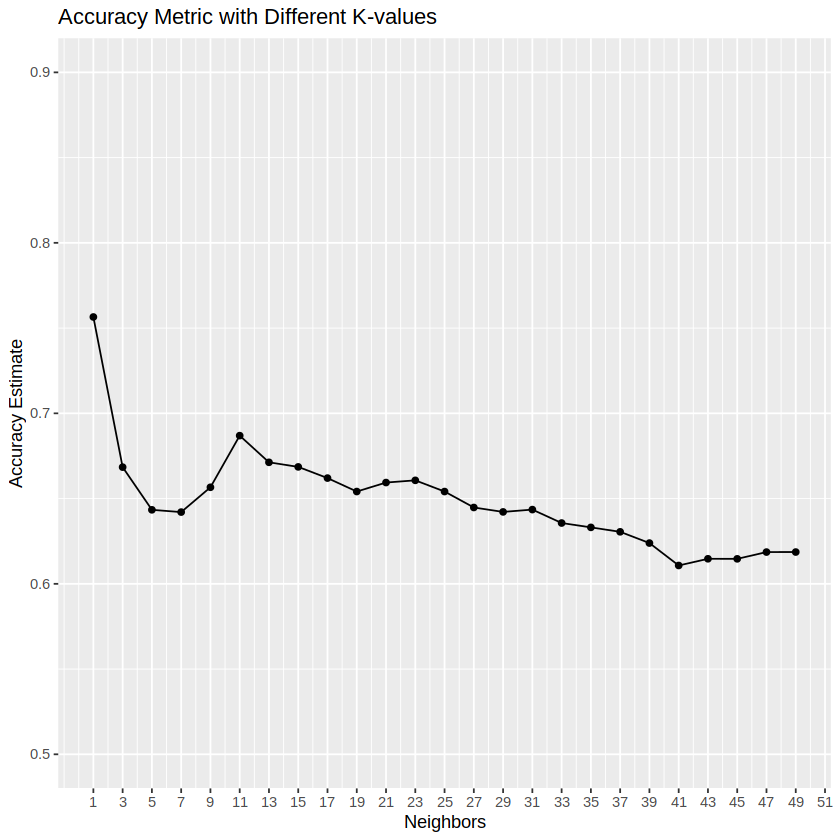

In [9]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Metric with Different K-values") +
      scale_x_continuous(breaks = seq(1, 51, by = 2)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.5, 0.9)) # adjusting the y-axis


accuracy_versus_k

### Observation
From the graph above, we can see that the K-value of 1 is the most accurate hyperparameter setting. However, to further proof 1 is the best value, we will explore more on the range of 1 to 3.

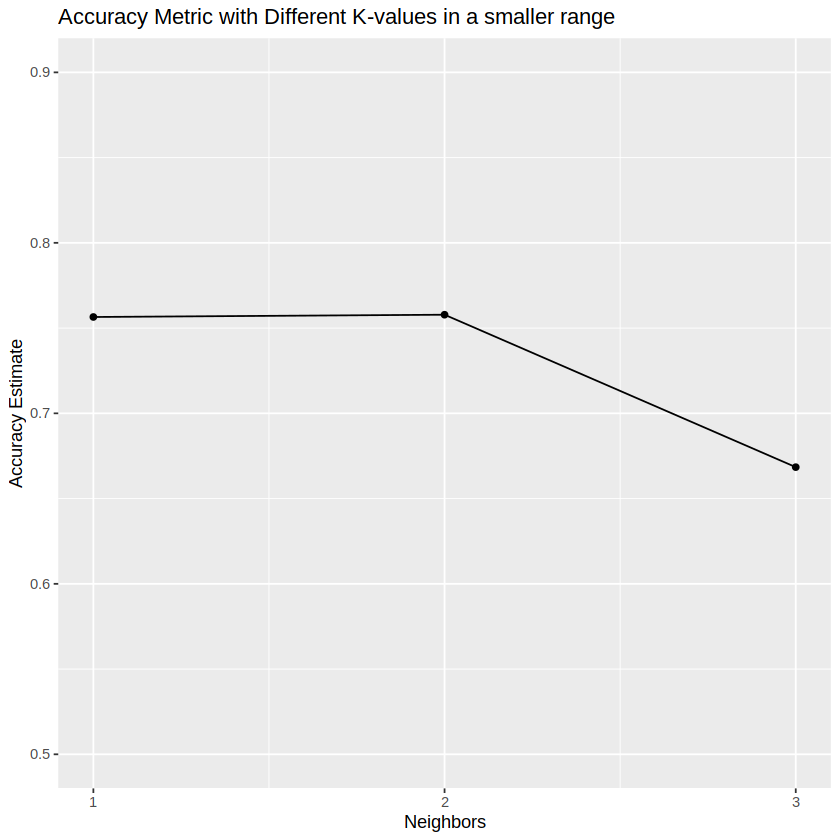

In [10]:
# A smaller range for the k values tibble
k_vals_small <- tibble(neighbors = seq(from = 1, to = 3))

health_fit_small_range <- workflow() |>
    add_recipe(health_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = health_vfold, grid = k_vals_small, control = control_grid(save_workflow = TRUE))

knn_results_small_range <- health_fit_small_range |>
          collect_metrics()

# Obtain the accuracies for K = 1-3
accuracies_small_range <- knn_results_small_range |> 
      filter(.metric == "accuracy")

accuracy_versus_k_small_range <- ggplot(accuracies_small_range, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Metric with Different K-values in a smaller range") +
      scale_x_continuous(breaks = seq(1, 3)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.5, 0.9)) # adjusting the y-axis


accuracy_versus_k_small_range

## Observation and Conclusion

The value of 1 and 2 are having similar accuracy, so picking both values would be reasonable. However, picking the value of 1 can be problematic, since it means predicting the new observation with the closest neighbor in the training dataset. ***Therefore, we will pick k = 2 for our model to lower the risk of overfitting.***

## Build a model with k = 2

In [11]:
# Model with k = 2
knn_spec_k2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
        set_engine("kknn") |>
        set_mode("classification") 

health_fit_k2 <- workflow() |>
    add_recipe(health_recipe) |>
    add_model(knn_spec_k2) |>
    fit(health_train)

health_pred_k2 <- predict(health_fit_k2, health_test) |>
    bind_cols(health_test) |>
    mutate(.pred_class = as_factor(.pred_class)) |>
    mutate(RiskLevel = as_factor(RiskLevel)) |>
    mutate(RiskLevel = RiskLevel |> fct_relevel("low risk", "mid risk", "high risk")) |>
    mutate(.pred_class = .pred_class |> fct_relevel("low risk", "mid risk", "high risk"))

health_pred_k2

.pred_class,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
high risk,29,90,70,8,100,80,high risk
high risk,30,140,85,7,98,70,high risk
high risk,35,85,60,11,102,86,high risk
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
low risk,55,140,80,7.2,101,76,high risk
high risk,25,120,90,12.0,101,80,high risk
high risk,43,120,90,18.0,98,70,high risk


## Accuracy

In [12]:
health_prediction_accuracy <- health_pred_k2 |>
                            metrics(truth = RiskLevel, estimate = .pred_class)

health_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7992126
kap,multiclass,0.6924501


## Confusion Matrix

In [19]:
health_conf_mat <- health_pred_k2 |>
    conf_mat(RiskLevel, .pred_class) 
health_conf_mat

           Truth
Prediction  low risk mid risk high risk
  low risk        89       19         6
  mid risk        12       59         7
  high risk        1        6        55

## References

Ahmed, M., Kashem, M. A., Rahman, M., & Khatun, S. (2020) Review and analysis of risk factor of maternal health in remote area using the internet of things (IoT). inecce2019 (pp. 357-365). Springer Singapore. https://doi.org/10.1007/978-981-15-2317-5_30

Say, L., Dr, Chou, D., MD, Gemmill, A., MPH, Tunçalp, Ö., MD, Moller, A., MSc, Daniels, J., PhD, Gülmezoglu, A. M., MD, Temmerman, M., MD, & Alkema, L., PhD. (2014). Global causes of maternal death: A WHO systematic analysis. The Lancet Global Health, 2(6), e323-e333. https://doi.org/10.1016/S2214-109X(14)70227-X